Fitting 5 folds for each of 8748 candidates, totalling 43740 fits
[0]	validation_0-logloss:0.65607
[1]	validation_0-logloss:0.64755
[2]	validation_0-logloss:0.63442
[3]	validation_0-logloss:0.62244
[4]	validation_0-logloss:0.61594
[5]	validation_0-logloss:0.60752
[6]	validation_0-logloss:0.60234
[7]	validation_0-logloss:0.59483
[8]	validation_0-logloss:0.59736
[9]	validation_0-logloss:0.59310
[10]	validation_0-logloss:0.58975
[11]	validation_0-logloss:0.59270
[12]	validation_0-logloss:0.59027
[13]	validation_0-logloss:0.58859
[14]	validation_0-logloss:0.58521
[15]	validation_0-logloss:0.57956
[16]	validation_0-logloss:0.57933
[17]	validation_0-logloss:0.57969
[18]	validation_0-logloss:0.58057
[19]	validation_0-logloss:0.58195
[20]	validation_0-logloss:0.58285
[21]	validation_0-logloss:0.57905
[22]	validation_0-logloss:0.58103
[23]	validation_0-logloss:0.58493
[24]	validation_0-logloss:0.58182
[25]	validation_0-logloss:0.58362
[26]	validation_0-logloss:0.58583
[27]	validation_0-logloss:

c:\Users\NT551\anaconda3\envs\project\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Best parameters: {'colsample_bytree': 0.6, 'gamma': 0.3, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0}
Best model accuracy: 0.6250
Best model F1 Score: 0.4000
Best model ROC AUC: 0.7667
Total time taken: 1019.47 seconds


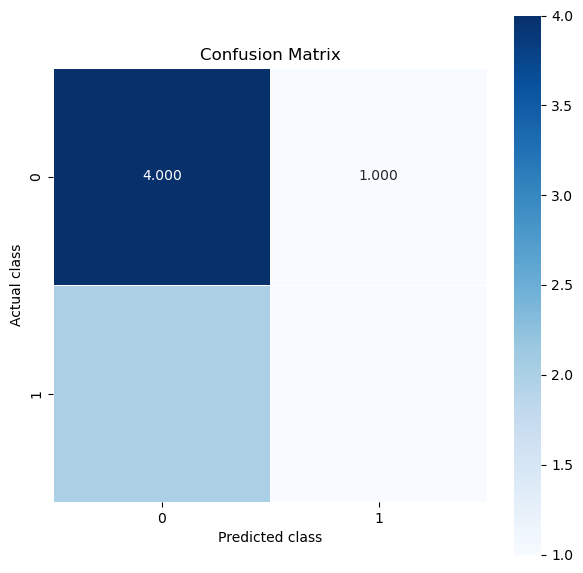

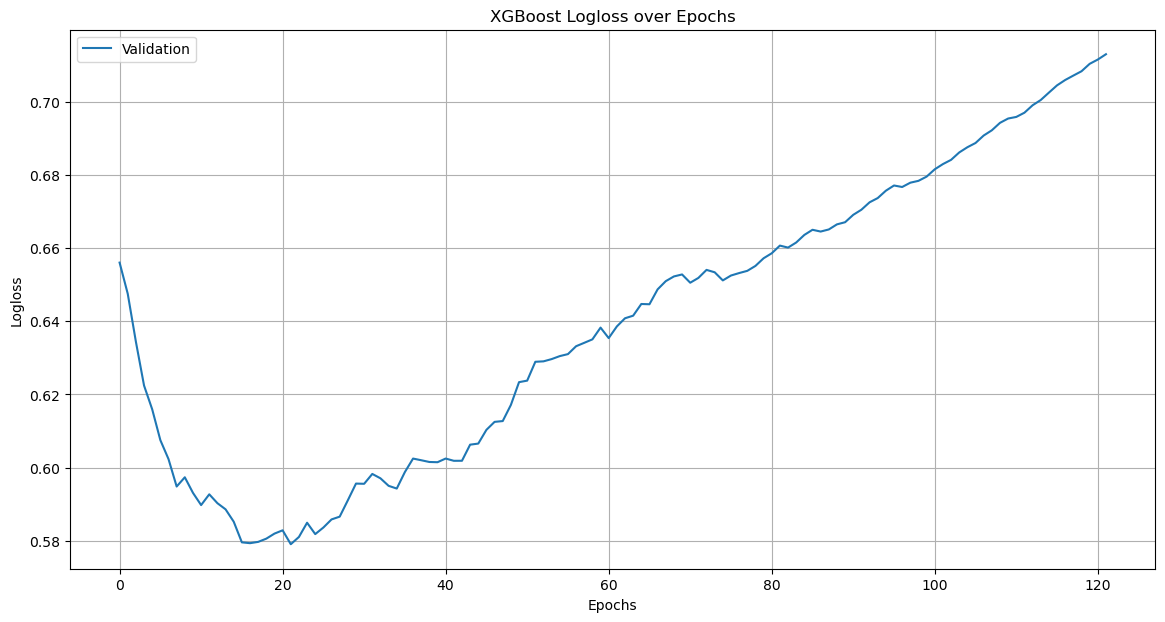

In [1]:
# 과적합
# stopping = 100 에서 과적합
# 수치 내려야할 듯 다른 파라미터 요소 건들어봐야할 예정
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time

# 데이터 불러오기
df = pd.read_excel('C:/Users/NT551/Desktop/데이터 추출(연습)/high_diamond_ranked_10min5.xlsx')

# 타겟 변수와 피처 변수 설정
y = df['blueWins']   # 목표 값
X = df.drop(columns=['blueWins', 'gameId']) # 예측에 사용할 나머지 데이터 (blueWins, gameId 제외)

# 데이터 전처리: 피처 스케일링
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 학습 데이터와 검증 데이터로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 하이퍼파라미터 값 리스트 설정
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10],
    'n_estimators': [300, 400, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_lambda': [1, 5, 10],
    'reg_alpha': [0, 1, 5]
}

# XGBoost 모델 초기화
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# F1 Score 및 ROC AUC 지표 설정
scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Grid Search 초기화
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,         # 5겹 교차 검증
    scoring=scoring,
    verbose=2,    # 학습 과정 자세히 출력
    n_jobs=-1,    # 병렬 처리
    refit='f1'    # F1 Score를 기준으로 최적 모델을 재학습
)

# 모델 학습
start_time = time.time()
grid_search.fit(X_train, y_train, early_stopping_rounds=100, eval_set=[(X_valid, y_valid)], verbose=True)
end_time = time.time()
elapsed_time = end_time - start_time

# 최적 하이퍼파라미터 출력
print(f'Best parameters: {grid_search.best_params_}')

# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_valid)
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]

# 최적 모델 평가
accuracy_best = accuracy_score(y_valid, y_pred_best)
f1_best = f1_score(y_valid, y_pred_best)
roc_auc_best = roc_auc_score(y_valid, y_pred_proba)

print(f'Best model accuracy: {accuracy_best:.4f}')
print(f'Best model F1 Score: {f1_best:.4f}')
print(f'Best model ROC AUC: {roc_auc_best:.4f}')

# 경과 시간 출력
print(f'Total time taken: {elapsed_time:.2f} seconds')

# 혼동 행렬 시각화
conf_mat = confusion_matrix(y_valid, y_pred_best)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_mat, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel("Actual class")
plt.xlabel("Predicted class")
plt.title("Confusion Matrix")
plt.show()

# 학습 과정 시각화
evals_result = best_model.evals_result()  # XGBClassifier의 evals_result 호출

epochs = len(evals_result['validation_0']['logloss'])
x_axis = range(0, epochs)

# 로그 손실 시각화
plt.figure(figsize=(14, 7))
plt.plot(x_axis, evals_result['validation_0']['logloss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Logloss')
plt.title('XGBoost Logloss over Epochs')
plt.legend()
plt.grid(True)
plt.show()
